# Long Notebook
-   Beatrice Re 104972
-   Claudio Di Salvo 105677
-   Raymond Li 105281

Group Name : 10 TimeBenders

In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from pycaret.regression import *


In [ ]:
def add_time_features(df, time_column):
    """
    Adds linear time features to a DataFrame for use in a LightGBM model.
    It extracts various time components like hour, day of week, month, day of year, week of year, and year.

    :param df: DataFrame to which the time features will be added.
    :param time_column: The name of the column in the DataFrame that contains datetime information.
    :return: The DataFrame with added time features.
    """
    df[time_column] = pd.to_datetime(df[time_column])  
    df['hour'] = df[time_column].dt.hour
    df['day_of_week'] = df[time_column].dt.dayofweek
    df['month'] = df[time_column].dt.month
    df['day_of_year'] = df[time_column].dt.dayofyear
    df['week_of_year'] = df[time_column].dt.isocalendar().week 
    df['year'] = df[time_column].dt.year
    
    return df

In [ ]:
# Time features nr 2
def add_time_features_cat(df, time_column):
    """
    Adds linear time features to a DataFrame for use in a Catboost model.
    It extracts various time components like hour, day of week, month, day of year, week of year, and year.

    :param df: DataFrame to which the time features will be added.
    :param time_column: The name of the column in the DataFrame that contains datetime information.
    :return: The DataFrame with added time features.
    """
    df[time_column] = pd.to_datetime(df[time_column])  
    
    df['sin_hour'] = np.sin(np.pi * df[time_column].dt.hour/23.)
    df['sin_month'] = np.sin(np.pi * df[time_column].dt.month/12.)
    
    return df

In [ ]:
def is_est(observed, estimated, test):
      
      estimated['time_dummy'] = (estimated['date_forecast'] - estimated['date_forecast'].dt.normalize()).dt.total_seconds() / 3600
      observed['time_dummy'] = 0 
      test['time_dummy'] = (test['date_forecast'] - test['date_forecast'].dt.normalize()).dt.total_seconds() / 3600
      
      estimated['time_delta'] = (estimated['date_calc'] - estimated['date_forecast']).dt.total_seconds() / 3600
      observed['time_delta'] = 0  # since observed data is not forecasting ahead
      test['time_delta'] = (test['date_calc'] - test['date_forecast']).dt.total_seconds() / 3600
      
      estimated['is_estimated'] = 1
      observed['is_estimated'] = 0
      test['is_estimated'] = 1
      df = pd.concat([observed, estimated], axis=0).sort_values(by='date_forecast')
      
      return df, test

In [ ]:
def preprocessing(targets, observed, estimated, test):
    """
    Preprocesses the data for LightGBM or CatBoost models.

    :param targets: DataFrame containing target values.
    :param observed: DataFrame with observed data.
    :param estimated: DataFrame with estimated data.
    :param test: DataFrame with test data.
    :param mode: Specifies the model type ('lgbm' or 'catboost'). Default is 'lgbm'.
    :return: Tuple containing preprocessed data for modeling and additional features.
    """

    targets['time'] = pd.to_datetime(targets['time'])
    observed['date_forecast'] = pd.to_datetime(observed['date_forecast'])
    estimated['date_forecast'] = pd.to_datetime(estimated['date_forecast'])
    test['date_forecast'] = pd.to_datetime(test['date_forecast'])

    date_calc_resampled_ob = estimated.set_index('date_forecast')['date_calc'].resample('1H').first().to_frame()
    date_calc_resampled_te = test.set_index('date_forecast')['date_calc'].resample('1H').first().to_frame()
    
    observed_resampled = observed.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    test_resampled = test.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    
    estimated_resampled = estimated_resampled.merge(date_calc_resampled_ob, left_on='date_forecast', right_index=True)
    test_resampled = test_resampled.merge(date_calc_resampled_te, left_on='date_forecast', right_index=True)
    
    is_day_feature = test_resampled[['date_forecast', 'is_day:idx']]
    
    #Drop some noise
    test_resampled = test_resampled.drop(columns =['is_day:idx', 'snow_density:kgm3','elevation:m'])
    observed_resampled = observed_resampled.drop(columns =[ 'is_day:idx', 'snow_density:kgm3','elevation:m'])
    estimated_resampled = estimated_resampled.drop(columns =[ 'is_day:idx', 'snow_density:kgm3','elevation:m'])
    
    weather_data, test_resampled = is_est(observed_resampled, estimated_resampled, test_resampled)
    
    merged_data = pd.merge(targets, weather_data, how='inner', left_on='time', right_on='date_forecast')

    # Add the time-based features
    merged_data = add_time_features(merged_data, 'time')  
    test_resampled = add_time_features(test_resampled, 'date_forecast') 
    
    # Remove data where targes are zero as its no reason to train for this
    merged_data = merged_data[merged_data['pv_measurement'] != 0]

    """
    Removes constant stretches from the 'pv_measurement' column in a DataFrame. 
    This function is intended to address stationarity by identifying and removing blocks 
    where 'pv_measurement' remains constant for more than two consecutive data points.
    """
    merged_data['diff'] = merged_data['pv_measurement'].diff().fillna(0)

    merged_data['constant'] = (merged_data['diff'] == 0).astype(int)
    merged_data['block'] = (merged_data['constant'].diff() != 0).astype(int).cumsum()
    block_sizes = merged_data.groupby('block')['constant'].sum()
    constant_blocks = block_sizes[block_sizes > 2].index
    filtered_data = merged_data[~merged_data['block'].isin(constant_blocks)]

    # Drop time and temporary features
    targets_ny = filtered_data[ ['time', 'pv_measurement']]
    filtered_data = filtered_data.drop(columns=['diff', 'constant', 'block'])
    
    
    # Drop time features
    filtered_data = filtered_data.drop(columns=['time', 'pv_measurement','date_calc'])
    test_resampled = test_resampled.drop(columns=[ 'date_forecast', 'date_calc'])
    
    return filtered_data, test_resampled, is_day_feature, targets_ny

### Preprocessing for catboost models

In [ ]:

def is_est_cat(observed, estimated, test):
      # Add indicator variable for estimated data
      estimated['is_estimated'] = 1
      observed['is_estimated'] = 0
      test['is_estimated'] = 1

      # Merge or concatenate data
      df = pd.concat([observed, estimated], axis=0).sort_values(by='date_forecast')
      
      return df, test

In [ ]:
def preprocessing_cat(targets, observed, estimated, test):
    """
    Preprocesses the data for LightGBM or CatBoost models.

    :param targets: DataFrame containing target values.
    :param observed: DataFrame with observed data.
    :param estimated: DataFrame with estimated data.
    :param test: DataFrame with test data.
    :param mode: Specifies the model type ('lgbm' or 'catboost'). Default is 'lgbm'.
    :return: Tuple containing preprocessed data for modeling and additional features.
    """
    targets['time'] = pd.to_datetime(targets['time'])
    observed['date_forecast'] = pd.to_datetime(observed['date_forecast'])
    estimated['date_forecast'] = pd.to_datetime(estimated['date_forecast'])
    test['date_forecast'] = pd.to_datetime(test['date_forecast'])

    date_calc_resampled_ob = estimated.set_index('date_forecast')['date_calc'].resample('1H').first().to_frame()
    date_calc_resampled_te = test.set_index('date_forecast')['date_calc'].resample('1H').first().to_frame()
    
    observed_resampled = observed.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    test_resampled = test.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    
    estimated_resampled = estimated_resampled.merge(date_calc_resampled_ob, left_on='date_forecast', right_index=True)
    test_resampled = test_resampled.merge(date_calc_resampled_te, left_on='date_forecast', right_index=True)
    
    is_day_feature = test_resampled[['date_forecast', 'is_day:idx']]
    
    #Drop some noise
    test_resampled = test_resampled.drop(columns =['is_day:idx', 'snow_density:kgm3','elevation:m'])
    observed_resampled = observed_resampled.drop(columns =[ 'is_day:idx', 'snow_density:kgm3','elevation:m'])
    estimated_resampled = estimated_resampled.drop(columns =[ 'is_day:idx', 'snow_density:kgm3','elevation:m'])
   
    # Filter observed and estimated data for April to August
    observed_resampled = observed_resampled[observed_resampled['date_forecast'].dt.month.isin([4, 5, 6, 7, 8])]
    estimated_resampled = estimated_resampled[estimated_resampled['date_forecast'].dt.month.isin([4, 5, 6, 7, 8])]
    targets = targets[targets['time'].dt.month.isin([4, 5, 6, 7, 8])]
    
    weather_data, test_resampled = is_est_cat(observed_resampled, estimated_resampled, test_resampled)
    merged_data = pd.merge(targets, weather_data, how='inner', left_on='time', right_on='date_forecast')
    merged_data = add_time_features_cat(merged_data, 'time')  
    test_resampled = add_time_features_cat(test_resampled, 'date_forecast')
    
    """
    Removes constant stretches from the 'pv_measurement' column in a DataFrame. 
    This function is intended to address stationarity by identifying and removing blocks 
    where 'pv_measurement' remains constant for more than two consecutive data points.
    """
    merged_data = merged_data[merged_data['pv_measurement'] != 0]

    merged_data['diff'] = merged_data['pv_measurement'].diff().fillna(0)

    merged_data['constant'] = (merged_data['diff'] == 0).astype(int)

    merged_data['block'] = (merged_data['constant'].diff() != 0).astype(int).cumsum()

    block_sizes = merged_data.groupby('block')['constant'].sum()

    constant_blocks = block_sizes[block_sizes > 2].index
    filtered_data = merged_data[~merged_data['block'].isin(constant_blocks)]
    
    targets_ny = filtered_data[ ['time', 'pv_measurement']]
    filtered_data = filtered_data.drop(columns=['diff', 'constant', 'block'])
    
    # Drop some time features
    filtered_data = filtered_data.drop(columns=['time', 'date_forecast', 'pv_measurement','date_calc'])
    test_resampled = test_resampled.drop(columns=[ 'date_forecast','date_calc'])
    
    return filtered_data, test_resampled, is_day_feature, targets_ny

In [ ]:
locations = ['A','B','C']

### LightGBM

In [ ]:
def train_lgbm(X, y, location_name,seeds):
    
    # Combine feature data and target into a single DataFrame
    data = X.copy()
    data['target'] = y['pv_measurement']

    # Feature Combination 1: Solar Radiation and Cloud Cover Combination
    # This feature represents a combination of direct and diffuse radiation adjusted by total cloud cover.
    # It aims to provide a more nuanced representation of solar radiation considering cloud cover impact.
    data['weighted_rad'] = ((data['direct_rad:W'] * (1 - data['total_cloud_cover:p']/100)) +
                        (data['diffuse_rad:W'] * (data['total_cloud_cover:p']/100)))

    # Feature Combination 2: Atmospheric Conditions Combination
    # This feature adjusts the clear sky radiation based on absolute humidity and air density.
    # It's an advanced representation considering the impact of atmospheric conditions on solar radiation.
    data['adjusted_clear_sky_rad'] = (data['clear_sky_rad:W'] * np.exp(-0.0001 * data['absolute_humidity_2m:gm3']) *
                                      (1 - 0.1 * (data['air_density_2m:kgm3'] - 1.225)))

    
    # Setup the environment in PyCaret
    exp_reg = setup(data=data, target='target', session_id=seeds,
                    imputation_type="iterative", categorical_iterative_imputer="lightgbm", numeric_iterative_imputer="lightgbm", iterative_imputation_iters = 5,
                    categorical_features=['dew_or_rime:idx', 'is_in_shadow:idx','is_estimated'],
                    html=True, 
                    experiment_name=f'exp_{location_name}')

    # Create a LightGBM model
    lightgbm = create_model('lightgbm')
    
    # Tune the model
    tuned_lightgbm = tune_model(lightgbm)#, early_stopping=True, fold=15)

    # Create a bagged version of the tuned model
    bagged_lightgbm = ensemble_model(tuned_lightgbm, method='Bagging')

    # Finalize the model by training on whole dataset
    final_model = finalize_model(bagged_lightgbm)
        
    return final_model

In [193]:
# LightGBM training and predictions
all_predictions_lGBM_e = []
for loc in locations:

    # Load your data
    train = pd.read_parquet(f'{loc}/train_targets.parquet').fillna(0)
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    X_train_observed = pd.read_parquet(f'{loc}/X_train_observed.parquet')
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')
    
    # Calling preprocessing
    X_train_1, X_test_1, is_day_feature_1, targets_1 = preprocessing(train, X_train_observed, X_train_estimated, X_test_estimated)
    
    # Adding the extra features to the test set as well
    X_train_1 = X_train_1.drop(columns=['date_forecast'])
    X_test_1['weighted_rad'] = ((X_test_1['direct_rad:W'] * (1 - X_test_1['total_cloud_cover:p']/100)) +
                        (X_test_1['diffuse_rad:W'] * (X_test_1['total_cloud_cover:p']/100)))

    X_test_1['adjusted_clear_sky_rad'] = (X_test_1['clear_sky_rad:W'] *
                                  np.exp(-0.0001 * X_test_1['absolute_humidity_2m:gm3']) *
                                  (1 - 0.1 * (X_test_1['air_density_2m:kgm3'] - 1.225)))
    
    # Training and prediction for diffrent seeds
    total_predictions_light = None
    seeds = [42]
    for seed in seeds: 
        final_model_lGBM_e = train_lgbm(X_train_1, targets_1, loc, seed)
        predictions_lGBM_e = predict_model(final_model_lGBM_e, data=X_test_1)
        final_predictions_lGBM_e = predictions_lGBM_e['prediction_label']
        if total_predictions_light is None:
            total_predictions_light = np.zeros_like(final_predictions_lGBM_e)
        total_predictions_light += final_predictions_lGBM_e

    mean_pred_light = total_predictions_light/len(seeds)
    
    #post_process
    adjusted_final_predictions_lGBM_e = mean_pred_light * is_day_feature_1['is_day:idx']

    # Setting negative predictions to zero
    adjusted_final_predictions_lGBM_e = np.clip(adjusted_final_predictions_lGBM_e, 0, None)

    # Appening predictions for each location to final list
    all_predictions_lGBM_e.append([adjusted_final_predictions_lGBM_e])

# Changing final list to array
all_predictions_lGBM_e = np.array(all_predictions_lGBM_e)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,329.4455,283530.7764,532.4761,0.8496,0.8797,3.2855
1,330.8892,288854.7799,537.4521,0.8490,0.7959,2.1113
2,333.8657,300975.8738,548.6127,0.8484,0.8145,1.8647
3,337.0255,303563.0383,550.9656,0.8465,0.8582,2.8491
4,312.0093,264065.9680,513.8735,0.8557,0.8858,2.6833
5,340.4875,292427.9278,540.7661,0.8479,0.8711,2.9202
6,331.6774,286577.8131,535.3296,0.8350,0.8492,2.3828
7,339.9131,297160.8284,545.1246,0.8470,0.8496,2.3176
8,295.1791,232207.9046,481.8796,0.8709,0.8744,3.0802


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 

### Catboost 1

In [194]:
def catboost_2(X, y, location_name,seeds):
    
    # Dropping some features for this one model
    features_to_drop = ['dew_or_rime:idx', #'snow_density:kgm3',
                        'fresh_snow_3h:cm', 'fresh_snow_1h:cm', 'snow_drift:idx', 
                        'snow_depth:cm', 'wind_speed_w_1000hPa:ms', 'prob_rime:p', 
                        'fresh_snow_6h:cm', 'snow_melt_10min:mm', 
                        'fresh_snow_12h:cm', 'rain_water:kgm2', 
                        'super_cooled_liquid_water:kgm2']
    
    X = X.drop(columns=features_to_drop)
    
    data = X.copy()
    data['target'] = y['pv_measurement']
    
    # Setup the environment in PyCaret
    exp_reg = setup(data=data, target='target', session_id=seeds,
                    imputation_type="iterative", categorical_iterative_imputer="lightgbm", numeric_iterative_imputer="lightgbm", iterative_imputation_iters = 5,
                    html=True,
                    experiment_name=f'exp_{location_name}')

    # Create a Catboost model
    cat = create_model('catboost')

    # Tune the model
    tuned_cat = tune_model(cat)
    
    # Create a bagged version of the tuned model
    bagged_cat = ensemble_model(tuned_cat, method='Bagging')

    # Train on whole dataset
    final_model = finalize_model(bagged_cat)
        
    return final_model

In [195]:
all_predictions_cat_2 = []
for loc in locations:
    # Load your data
    train = pd.read_parquet(f'{loc}/train_targets.parquet').fillna(0)
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    X_train_observed = pd.read_parquet(f'{loc}/X_train_observed.parquet')
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

    # Calling preprocessing
    X_train, X_test, is_day_feature, targets = preprocessing(train, X_train_observed, X_train_estimated, X_test_estimated)

    # Dropping date feature
    X_train = X_train.drop(columns=['date_forecast'])

    # Training and prediction for diffrent seeds
    seeds = [42]
    total_predictions_cat_2 = None
    for seed in seeds: 
        final_model_cat_2 = catboost_2(X_train, targets, loc,seed)
        predictions_cat_2 = predict_model(final_model_cat_2, X_test)
        final_predictions_cat_2 = predictions_cat_2['prediction_label']
        if total_predictions_cat_2 is None:
            total_predictions_cat_2 = np.zeros_like(final_predictions_cat_2)
            total_predictions_cat_2+=final_predictions_cat_2

    mean_pred_cat_2 = total_predictions_cat_2/len(seeds)

    adjusted_final_predictions_cat_2 = mean_pred_cat_2 * is_day_feature['is_day:idx']
    adjusted_final_predictions_cat_2 = np.clip(adjusted_final_predictions_cat_2, 0, None)
    all_predictions_cat_2.append([adjusted_final_predictions_cat_2])
all_predictions_cat_2 = np.array(all_predictions_cat_2)

,Description,Value
0,Session id,42
1,Target,target
2,Target type,Regression
3,Original data shape,"(18038, 40)"
4,Transformed data shape,"(18038, 40)"
5,Transformed train set shape,"(12626, 40)"
6,Transformed test set shape,"(5412, 40)"
7,Numeric features,39
8,Rows with missing values,19.9%
9,Preprocess,True


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,331.5347,280088.3061,529.2337,0.8515,0.9573,4.4094
1,329.8633,282572.0687,531.5751,0.8523,0.9035,2.8594
2,330.1709,281579.4527,530.6406,0.8581,0.9094,3.5294
3,340.2220,302901.1310,550.3645,0.8468,0.9635,4.2181
4,311.7154,258253.4291,508.1864,0.8589,0.9887,4.1276
5,332.0868,275836.8078,525.2017,0.8565,0.9528,3.9372
6,327.8728,288634.4182,537.2471,0.8338,0.9640,3.7622
7,343.9738,296294.5591,544.3295,0.8475,0.9642,4.1479
8,297.9808,225688.0367,475.0663,0.8745,0.9624,4.6959


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,373.7750,347800.1610,589.7458,0.8155,0.9998,5.4426
1,376.3020,357862.4528,598.2161,0.8129,0.9240,3.4955
2,372.8907,353602.6585,594.6450,0.8219,0.9237,2.8008
3,369.0966,350865.7319,592.3392,0.8226,0.9733,4.1112
4,350.0916,314306.3659,560.6303,0.8283,1.0124,4.6743
5,383.1707,355459.8671,596.2046,0.8151,0.9840,4.2884
6,374.6368,349193.2898,590.9258,0.7989,1.0071,5.1602
7,394.0195,374185.4020,611.7070,0.8074,0.9794,3.5532
8,327.8279,282676.6929,531.6735,0.8428,0.9712,4.4658


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,330.8393,280379.3867,529.5086,0.8513,0.9278,3.9378
1,331.4055,288341.1455,536.9741,0.8492,0.8880,2.8825
2,329.2066,290338.0350,538.8302,0.8537,0.8742,2.9036
3,335.5599,298457.0409,546.3122,0.8491,0.8987,3.7164
4,309.5971,261297.1835,511.1724,0.8572,0.9686,3.5521
5,334.3443,281169.8822,530.2545,0.8537,0.8949,3.3587
6,330.4999,288589.0153,537.2048,0.8338,0.9092,3.3626
7,344.4032,303321.0872,550.7459,0.8439,0.9245,3.4580
8,295.8456,228783.1977,478.3129,0.8728,0.9317,3.9928


### Catboost 2

In [197]:
all_predictions_cat = []
for loc in locations:
    
    # Load your data
    train = pd.read_parquet(f'{loc}/train_targets.parquet').fillna(0)
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    X_train_observed = pd.read_parquet(f'{loc}/X_train_observed.parquet')
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

    # Calling preprocessing
    X_train, X_test, is_day_feature1, targets_cat = preprocessing_cat(train, X_train_observed, X_train_estimated, X_test_estimated)

    # Making categorical features
    cat_features = ['dew_or_rime:idx' ,'is_in_shadow:idx']
    X_train['dew_or_rime:idx'] = X_train['dew_or_rime:idx'].astype(int)
    X_train['is_in_shadow:idx'] = X_train['is_in_shadow:idx'].astype(int)
    X_test['dew_or_rime:idx'] = X_test['dew_or_rime:idx'].astype(int)
    X_test['is_in_shadow:idx'] = X_test['is_in_shadow:idx'].astype(int)

    # Catboooooooozt fun
    model_cat = CatBoostRegressor(
        loss_function='MAE', 
        learning_rate=0.1, 
        verbose=200,
        cat_features=cat_features,
        random_state=42) 
    # Training
    model_cat.fit(X_train,targets_cat['pv_measurement'])

    # Prediction
    predictions_cat = model_cat.predict(X_test)
    feature_importances = model_cat.get_feature_importance()
    # Multiplying the predictions with is_day, so setting predictions at night to zero
    adjusted_final_predictions_cat = predictions_cat * is_day_feature1['is_day:idx']

    # Setting negative predictions to zero
    adjusted_final_predictions_cat = np.clip(adjusted_final_predictions_cat, 0, None)

    # Appening predictions for each location to final list
    all_predictions_cat.append(adjusted_final_predictions_cat)

# Changing final list to array
all_predictions_cat = np.array(all_predictions_cat)

0:	learn: 1098.0450846	total: 43.5ms	remaining: 43.4s
200:	learn: 364.8966719	total: 9.19s	remaining: 36.5s
400:	learn: 328.6032161	total: 19.1s	remaining: 28.6s
600:	learn: 306.8253447	total: 28.2s	remaining: 18.7s
800:	learn: 291.9455358	total: 36.8s	remaining: 9.14s
999:	learn: 280.1029739	total: 44.8s	remaining: 0us


### Catboost 3

In [199]:
all_predictions_cat_3 = []
for loc in locations:
    # Load your data
    train = pd.read_parquet(f'{loc}/train_targets.parquet').fillna(0)
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    X_train_observed = pd.read_parquet(f'{loc}/X_train_observed.parquet')
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

    # Calling preprocessing
    X_train_3, X_test_3, is_day_feature_3, targets_3 = preprocessing(train, X_train_observed, X_train_estimated, X_test_estimated)

    # Dropping date feature
    X_train_3 = X_train_3.drop(columns=['date_forecast'])
    
    model_cat_3 = CatBoostRegressor(
                                    verbose=200, 
                                    learning_rate=0.03,
                                    depth=10,
                                    l2_leaf_reg=5,
                                    random_state=42, 
                                    n_estimators=20000, 
                                    loss_function='MAE', 
                                    early_stopping_rounds=100,)
    '''
    Adds engineered features based on the sun azimuth angle to the DataFrame.

    This function calculates the sine and cosine of the sun azimuth angle, 
    which can be useful for capturing cyclical patterns related to the sun's position.
    '''
    X_train_3['sin_sun_azimuth'] = np.sin(np.radians(X_train_3['sun_azimuth:d']))
    X_train_3['cos_sun_azimuth'] = np.cos(np.radians(X_train_3['sun_azimuth:d']))
    X_test_3['sin_sun_azimuth'] = np.sin(np.radians(X_test_3['sun_azimuth:d']))
    X_test_3['cos_sun_azimuth'] = np.cos(np.radians(X_test_3['sun_azimuth:d']))

    X_train_3.drop('sun_azimuth:d', axis=1, inplace=True)
    X_test_3.drop('sun_azimuth:d', axis=1, inplace=True)
  
    # Split the training data into training and validation sets
    X_train_cat_3, X_test_cat_3, y_train_cat_3, y_test_cat_3 = train_test_split(X_train_3, targets_3, test_size=0.2, random_state=42)

    # Train model
    model_cat_3.fit(X_train_cat_3, y_train_cat_3['pv_measurement'],eval_set=(X_test_cat_3, y_test_cat_3['pv_measurement']),)  
    
    pred_cat_3 = model_cat_3.predict(X_test_3)

    adjusted_final_predictions_cat_3 = pred_cat_3 * is_day_feature_3['is_day:idx']

    adjusted_final_predictions_cat_3 = np.clip(adjusted_final_predictions_cat_3, 0, None)
    all_predictions_cat_3.append(adjusted_final_predictions_cat_3) 
all_predictions_cat_3 = np.array(all_predictions_cat_3)

0:	learn: 981.0541229	test: 986.5219433	best: 986.5219433 (0)	total: 75.6ms	remaining: 25m 11s
200:	learn: 320.9450192	test: 341.6960508	best: 341.6960508 (200)	total: 17.1s	remaining: 28m 2s
400:	learn: 281.8109323	test: 323.5911619	best: 323.5911619 (400)	total: 32.7s	remaining: 26m 40s
600:	learn: 246.4965531	test: 313.0847849	best: 313.0847849 (600)	total: 49.6s	remaining: 26m 40s
800:	learn: 217.5035448	test: 306.7147854	best: 306.7147854 (800)	total: 1m 9s	remaining: 27m 39s
1000:	learn: 190.6737885	test: 302.6330363	best: 302.6323358 (999)	total: 1m 26s	remaining: 27m 15s
1200:	learn: 174.3532699	test: 299.9268452	best: 299.9268452 (1200)	total: 1m 44s	remaining: 27m 8s
1400:	learn: 160.3087673	test: 297.9194447	best: 297.9095416 (1398)	total: 1m 59s	remaining: 26m 20s
1600:	learn: 150.9765890	test: 296.3387070	best: 296.3278847 (1598)	total: 2m 14s	remaining: 25m 41s
1800:	learn: 142.7118904	test: 295.0725273	best: 295.0579019 (1794)	total: 2m 30s	remaining: 25m 19s
2000:	learn

In [200]:
all_predictions_lGBM_e = np.array(all_predictions_lGBM_e).flatten()
all_predictions_cat = np.array(all_predictions_cat).flatten()
all_predictions_cat_2 = np.array(all_predictions_cat_2).flatten()
all_predictions_cat_3 = np.array(all_predictions_cat_3).flatten()
all_pred = 0.25*all_predictions_cat+0.25 * all_predictions_lGBM_e+ 0.25* all_predictions_cat_2+0.25*all_predictions_cat_3
all_pred[all_pred < 6] = 0
print(all_pred.shape)

(720,)


In [201]:

final_predictions = all_pred

# Save the final_predictions to CSV
df = pd.DataFrame(final_predictions, columns=['prediction'])
df['id'] = df.index
df = df[['id', 'prediction']]
df.to_csv('final_predictions.csv', index=False)

<Axes: >

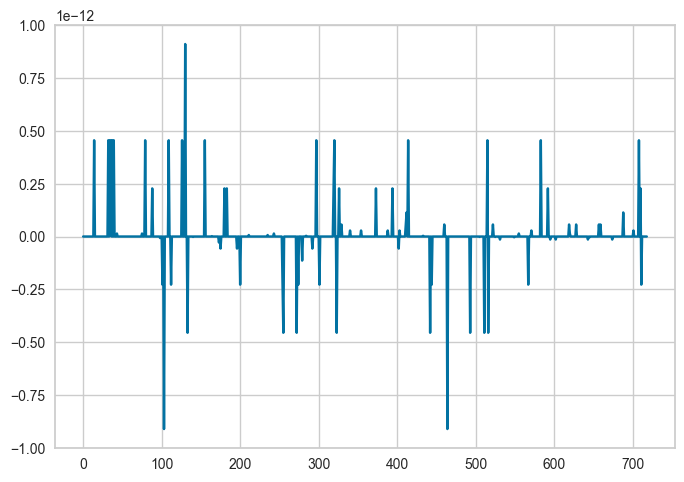

In [202]:
df1 = pd.read_csv('final_predictions_ok.csv')
df_diff = df1[0:719]['prediction'] - df[0:719]['prediction']
df_diff.plot()